# Preprocess UCK data for COVID-19 severity prognosis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

## CBC data preprocessing
Read dataframe with CBC results.

In [2]:
features = ['HGB', 'PLT', 'WBC', '% LYMPH'] # Input features of the severity model

df_morf = pd.read_csv('../datasets/raw/uck-data/tests/Morfologia.csv') # Raw data with ungrouped lab results
df_morf = df_morf[['atrybut_kod', 'pacjent_id', 'badanie_data', 'numer_badania', 'wartosc']] # Columns needed for matching data

df_morf = df_morf.loc[df_morf['atrybut_kod'].isin(features)] # Limit rows to those describing model severity
df_morf['badanie_data'] = pd.to_datetime(df_morf['badanie_data'])
df_morf.reset_index(drop=True, inplace=True)
df_morf

,atrybut_kod,pacjent_id,badanie_data,numer_badania,wartosc
0,HGB,100055,2020-08-07 11:56:00,CN63395434,11.7
1,PLT,100055,2020-08-07 11:56:00,CN63395434,176
2,WBC,100055,2020-08-07 11:56:00,CN63395434,6.54
3,% LYMPH,100055,2020-08-07 11:56:00,CN63395434,24.9
4,HGB,100075,2020-07-02 10:42:00,CN62380748,13.7
...,...,...,...,...,...
497698,% LYMPH,99960,2020-11-14 08:49:00,CN65593354,6.7
497699,HGB,99960,2020-11-27 14:49:00,CN66582744,10.0
497700,PLT,99960,2020-11-27 14:49:00,CN66582744,89
497701,WBC,99960,2020-11-27 14:49:00,CN66582744,0.80


The values of Complete Blood Count features were inserted manually and contain typos. Fix them to be valid numbers. 

In [3]:
import re
for idx, row in df_morf.iterrows():
    col = 'wartosc' # The name of a column with a parameter value
    if str(row[col]):
        num = str(row[col])
        if ',' in num: # Replace commas with dots to match English numeral conventions.
            num = num.replace(',', '.')
        num = re.findall(r"[-+]?\d*\.\d+|\d+", num) # Extract only a number from the cell
        if len(num) > 0: # If the cell contains a number.
            num = num[0]
            df_morf[col].iat[idx] = float(num) # Replace the value in cell with just the number.
        else:
            df_morf[col].iat[idx] = None # If a valid number wasn't found, replace cell contents with None.

Change type of CBC feature value column to numeric. It should run without errors after preprocessing in cell above.

In [4]:
df_morf['wartosc'] = pd.to_numeric(df_morf['wartosc'], downcast="float")

Create a table aggregating records of all features tested in a single CBC test to a single row in a pivot table.

In [5]:
df_cbc = pd.pivot_table(df_morf, index = ['numer_badania', 'pacjent_id', 'badanie_data'], values=['wartosc'], columns=['atrybut_kod'])
df_cbc

wartosc                    
atrybut_kod                                     % LYMPH   HGB    PLT    WBC
numer_badania pacjent_id badanie_data                                      
CN37415815    1640622    2020-02-12 09:28:00  22.100000  14.6  324.0  12.11
CN39640263    1649146    2019-11-12 08:44:00  22.400000  16.0  262.0   6.80
CN41703049    189651     2019-10-31 13:12:00  25.000000  12.8  163.0   5.31
CN42580687    89507      2019-05-28 11:28:00  21.200001  12.2  308.0   8.39
CN42711457    254279     2020-07-21 08:26:00  30.299999  12.8  222.0   6.63
...                                                 ...   ...    ...    ...
CN66802904    1766501    2020-12-04 18:21:00  17.799999  13.0  262.0   8.66
CN66804052    1951400    2020-12-04 19:51:00  12.700000  10.9  365.0  10.10
CN66804216    1098876    2020-12-04 19:35:00  20.799999  13.5  230.0   7.21
CN66804331    323440     2020-12-04 19:34:00   8.700000  12.8  244.0  11.25
CN66804507    2110197    2020-12-04 20:19:00  35.000000  16.6  274.0   8.54

[123829 rows x 4 columns]

Change the pivot table to a regular dataframe. Change column names to their English counterparts.

In [6]:
df_cbc = pd.DataFrame(df_cbc.to_records())
df_cbc = df_cbc.rename(columns = {
    "('wartosc', '% LYMPH')": 'LYT',
    "('wartosc', 'HGB')": 'HGB',
    "('wartosc', 'PLT')": 'PLT',
    "('wartosc', 'WBC')": 'WBC'
})
df_cbc

,numer_badania,pacjent_id,badanie_data,LYT,HGB,PLT,WBC
0,CN37415815,1640622,2020-02-12 09:28:00,22.100000,14.6,324.0,12.11
1,CN39640263,1649146,2019-11-12 08:44:00,22.400000,16.0,262.0,6.80
2,CN41703049,189651,2019-10-31 13:12:00,25.000000,12.8,163.0,5.31
3,CN42580687,89507,2019-05-28 11:28:00,21.200001,12.2,308.0,8.39
4,CN42711457,254279,2020-07-21 08:26:00,30.299999,12.8,222.0,6.63
...,...,...,...,...,...,...,...
123824,CN66802904,1766501,2020-12-04 18:21:00,17.799999,13.0,262.0,8.66
123825,CN66804052,1951400,2020-12-04 19:51:00,12.700000,10.9,365.0,10.10
123826,CN66804216,1098876,2020-12-04 19:35:00,20.799999,13.5,230.0,7.21
123827,CN66804331,323440,2020-12-04 19:34:00,8.700000,12.8,244.0,11.25


## PCR results preprocessing
Read the data from RT-PCR tests.

In [7]:
df_pcr = pd.read_csv('../datasets/raw/uck-data/TestResult.csv')
df_pcr

,pacjent_id,data_testu,wynik
0,2089489,2020-10-08 23:26:00,nie wykryto
1,1474205,2020-10-16 10:11:00,nie wykryto
2,1942712,2020-06-28 12:40:00,nie wykryto
3,630608,2020-11-10 07:38:00,nie wykryto
4,185736,2020-07-19 13:44:00,nie wykryto
...,...,...,...
34809,2076073,2020-10-30 10:52:00,nie wykryto
34810,2076073,2020-05-19 22:08:00,nie wykryto
34811,2076073,2020-10-19 12:36:00,nie wykryto
34812,2141180,2020-10-01 00:11:00,nie wykryto


Find the names of possible test outcomes.

In [8]:
df_pcr['wynik'].unique()

array(['nie wykryto', 'NISKODODATNI', nan, 'DODATNI',
       'wynik niejednoznaczny', 'wynik niskododatni', 'nie wyrkyto',
       'nie  wykryto', 'testowy dodatni', '*', 'nie wykryo', '*.',
       'niejednoznaczny', 'nire wykryto', 'nie wykrytonie wykryto',
       'nie wykrytowynik niejednoznaczny', 'niwe wykryto', '*,',
       'nie wykyto', 'nier wykryto', 'nnie wykryto',
       'wynik niejednoznaczy', 'niskododatni', 'NIE WYKRYTO',
       'nei wykryto', 'WYKRYTO'], dtype=object)

Select only patients with a negative RT-PCR result.

In [9]:
negative = dict.fromkeys(
    ['nie wykryto', 'nie wyrkyto', 'nie  wykryto', 'nie wykryo', 'nire wykryto', 'nie wykrytonie wykryto',
'niwe wykryto', 'nie wykyto', 'nier wykryto', 'nnie wykryto', 'NIE WYKRYTO', 'nei wykryto'], 0)
positive = dict.fromkeys(
    ['DODATNI', 'testowy dodatni', 'WYKRYTO'], 1)


df_pcr['wynik'] = df_pcr['wynik'].replace(negative)
df_pcr['wynik'] = df_pcr['wynik'].replace(positive)
df_pcr = df_pcr[df_pcr['wynik'] == 1]
df_pcr

,pacjent_id,data_testu,wynik
21,1860431,2020-11-18 08:13:00,1
32,2142164,2020-10-19 10:25:00,1
33,2142164,2020-10-16 08:49:05,1
37,1509900,2020-10-23 14:03:00,1
81,2152824,2020-11-15 19:22:04,1
...,...,...,...
34591,811037,2020-10-20 11:04:00,1
34635,2152732,2020-11-14 16:27:00,1
34702,2148554,2020-10-19 18:47:00,1
34743,2091305,2020-11-28 10:24:00,1


Match CBC tests with RT-PCR tests based on patient id.

In [10]:
df_cbc['pacjent_id'] = pd.to_numeric(df_cbc['pacjent_id'],errors='coerce')
df_pcr['pacjent_id'] = pd.to_numeric(df_pcr['pacjent_id'],errors='coerce')

df_cbc = df_cbc[df_cbc['pacjent_id'].notna()]
df_pcr = df_pcr[df_pcr['pacjent_id'].notna()]

df_severity = df_cbc.merge(df_pcr, on='pacjent_id', how='left').drop_duplicates()
df_severity

/tmp/ipykernel_28680/64756745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pcr['pacjent_id'] = pd.to_numeric(df_pcr['pacjent_id'],errors='coerce')


,numer_badania,pacjent_id,badanie_data,LYT,HGB,PLT,WBC,data_testu,wynik
0,CN37415815,1640622,2020-02-12 09:28:00,22.100000,14.6,324.0,12.11,NaN,NaN
1,CN39640263,1649146,2019-11-12 08:44:00,22.400000,16.0,262.0,6.80,NaN,NaN
2,CN41703049,189651,2019-10-31 13:12:00,25.000000,12.8,163.0,5.31,NaN,NaN
3,CN42580687,89507,2019-05-28 11:28:00,21.200001,12.2,308.0,8.39,NaN,NaN
4,CN42711457,254279,2020-07-21 08:26:00,30.299999,12.8,222.0,6.63,NaN,NaN
...,...,...,...,...,...,...,...,...,...
126122,CN66802904,1766501,2020-12-04 18:21:00,17.799999,13.0,262.0,8.66,NaN,NaN
126123,CN66804052,1951400,2020-12-04 19:51:00,12.700000,10.9,365.0,10.10,NaN,NaN
126124,CN66804216,1098876,2020-12-04 19:35:00,20.799999,13.5,230.0,7.21,NaN,NaN
126125,CN66804331,323440,2020-12-04 19:34:00,8.700000,12.8,244.0,11.25,NaN,NaN


Change type of columns with dates to datetime.

In [11]:
df_severity['badanie_data'] = pd.to_datetime(df_severity['badanie_data']).dt.date
df_severity['data_testu'] = pd.to_datetime(df_severity['data_testu']).dt.date
df_severity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126127 entries, 0 to 126126
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   numer_badania  126127 non-null  object 
 1   pacjent_id     126127 non-null  int64  
 2   badanie_data   126127 non-null  object 
 3   LYT            123976 non-null  float32
 4   HGB            126125 non-null  float32
 5   PLT            126122 non-null  float32
 6   WBC            126120 non-null  float32
 7   data_testu     8726 non-null    object 
 8   wynik          8726 non-null    object 
dtypes: float32(4), int64(1), object(4)
memory usage: 7.7+ MB


Match the CBC tests with RT-PCR tests for each patient to find a group of patients for whom we can determine if they were infected with SARS-CoV-2 during the CBC test.

In [12]:
time_delta = 1
df_sev_1 = df_severity.loc[((df_severity['data_testu'] - df_severity['badanie_data']).dt.days <= time_delta) & ((df_severity['data_testu'] - df_severity['badanie_data']).dt.days >= - time_delta)]
print(f"{time_delta}: {len(df_sev_1)}")
print(df_sev_1['wynik'].value_counts())

time_delta = 3
df_sev_3 = df_severity.loc[((df_severity['data_testu'] - df_severity['badanie_data']).dt.days <= time_delta) & ((df_severity['data_testu'] - df_severity['badanie_data']).dt.days >= - time_delta)]
print(f"{time_delta}: {len(df_sev_3)}")
print(df_sev_3['wynik'].value_counts())

1: 698
1    698
Name: wynik, dtype: int64
3: 1085
1    1085
Name: wynik, dtype: int64


# Care category preprocessing
Read data about care category.

In [13]:
df_care = pd.read_csv('../datasets/raw/uck-data/KategoriaOpieki.csv')
df_care['KATEGORIA'].value_counts()

III    2663
II     1216
I       252
Name: KATEGORIA, dtype: int64

Convert the columns with dates to datetime and rename care categories. Fill missing end dates with start dates from the same row.

In [14]:
df_care['KATEGORIA'] = df_care['KATEGORIA'].map({
    'I': 1,
    'II': 2,
    'III': 3
})
df_care['OBOWIAZUJE_OD'] = pd.to_datetime(df_care['OBOWIAZUJE_OD']).dt.date
df_care['OBOWIAZUJE_DO'] = pd.to_datetime(df_care['OBOWIAZUJE_DO']).dt.date

df_care['OBOWIAZUJE_OD'] = df_care['OBOWIAZUJE_OD'].fillna(df_care['OBOWIAZUJE_DO'])
df_care['OBOWIAZUJE_DO'] = df_care['OBOWIAZUJE_DO'].fillna(df_care['OBOWIAZUJE_OD'])

If the category of care changed during hospitalization, select category with the highest value. Create a new dataframe aggregating entries for a single stay to one row.

In [15]:
group = df_care.groupby('HOSPITALIZACJA_ID')['KATEGORIA'].unique()
care_cat = group.apply(lambda x: max(x))
arr = care_cat.values
df_care_agg = pd.DataFrame({'HOSPITALIZACJA_ID': care_cat.index, 'Category': care_cat.values})
df_care_agg

,HOSPITALIZACJA_ID,Category
0,5126988,2
1,5172050,2
2,5175409,2
3,5193183,3
4,5202899,1
...,...,...
335,5302191,2
336,5302210,2
337,5302638,3
338,5302696,2


Add patient_id column.

In [16]:
df_buffer = df_care[['HOSPITALIZACJA_ID', 'PACJENT_ID']]
df_care_agg = df_care_agg.join(df_buffer.set_index('HOSPITALIZACJA_ID'), on='HOSPITALIZACJA_ID')
df_care_agg = df_care_agg.drop_duplicates()
df_care_agg = df_care_agg.rename(columns = {'PACJENT_ID': 'pacjent_id'})
df_care_agg

,HOSPITALIZACJA_ID,Category,pacjent_id
0,5126988,2,176905
1,5172050,2,2016185
2,5175409,2,2134872
3,5193183,3,2140615
4,5202899,1,2141925
...,...,...,...
335,5302191,2,2157479
336,5302210,2,2148866
337,5302638,3,1932153
338,5302696,2,2020947


Find the actual start and end date for each hospital stay.

In [17]:
group = df_care.groupby('HOSPITALIZACJA_ID')['OBOWIAZUJE_OD'].unique()
start_date = group.apply(lambda x: min(x))
group = df_care.groupby('HOSPITALIZACJA_ID')['OBOWIAZUJE_DO'].unique()
end_date = group.apply(lambda x: max(x))

df_buffer = pd.DataFrame({'HOSPITALIZACJA_ID': group.index, 'start_date': start_date, 'end_date': end_date})
df_care_agg = df_care_agg.join(df_buffer.set_index('HOSPITALIZACJA_ID'), on='HOSPITALIZACJA_ID')

Add an acceptable time delta to each hospital stay to find more matches after merging with df_sevs.

In [18]:
df_care_agg['start_date'] = df_care_agg['start_date'] - pd.Timedelta(days=time_delta)
df_care_agg['end_date'] = df_care_agg['end_date'] + pd.Timedelta(days=time_delta)
df_care_agg

,HOSPITALIZACJA_ID,Category,pacjent_id,start_date,end_date
0,5126988,2,176905,2020-07-14,2020-07-23
1,5172050,2,2016185,2020-08-23,2020-09-01
2,5175409,2,2134872,2020-08-26,2020-09-02
3,5193183,3,2140615,2020-09-09,2020-09-16
4,5202899,1,2141925,2020-09-17,2020-09-23
...,...,...,...,...,...
335,5302191,2,2157479,2020-12-07,2020-12-14
336,5302210,2,2148866,2020-12-07,2020-12-14
337,5302638,3,1932153,2020-12-07,2020-12-14
338,5302696,2,2020947,2020-12-07,2020-12-14


Merge category of care data frame with df_sev. Select data with test date and hospital stay taking place no longer than time delta from one another.

In [19]:
df_sev_3_post = df_sev_3.merge(df_care_agg, on='pacjent_id', how='left').drop_duplicates()
df_sev_3_post['Category'] = df_sev_3_post['Category'].fillna(0)

time_delta = 3
df_sev_3_post = df_sev_3_post.loc[(df_sev_3_post['data_testu'] >= df_sev_3_post['start_date']) & (df_sev_3_post['data_testu'] <= df_sev_3_post['end_date']) | (df_sev_3_post['Category'] == 0)]

df_sev_3_post['pacjent_id'] = pd.to_numeric(df_sev_3_post['pacjent_id'], errors='coerce')

print(f"Sample count: {len(df_sev_3_post)}")
print(df_sev_3_post['Category'].value_counts())

Sample count: 997
0.0    544
3.0    398
2.0     48
1.0      7
Name: Category, dtype: int64


Check if it makes sense to use only the most recent CBC test for patients with multiple tests.

In [20]:
df_test = df_sev_3_post.sort_values('badanie_data').drop_duplicates('pacjent_id',keep='last')
pd.pivot_table(df_test, index = ['Category'], values=['LYT', 'HGB', 'PLT', 'WBC'], aggfunc='count')

,HGB,LYT,PLT,WBC
Category,,,,
0.0,316,313,316,316
1.0,3,3,3,3
2.0,22,21,22,22
3.0,154,154,154,154


Unfortunately we can't keep only most recent test for a patient due to limited availability of data.

## Patient info preprocessing
Read the data with sex and age.

In [29]:
df_patient = pd.read_csv('../datasets/raw/uck-data/Pacjent.csv')
df_patient

,pacjent_id,data_urodzenia,plec
0,1986978,1952-11-13 00:00:00,M
1,2125885,1976-06-06 00:00:00,K
2,2137871,1986-03-23 00:00:00,K
3,2139429,1952-02-02 00:00:00,K
4,1898419,2017-08-02 00:00:00,M
...,...,...,...
25436,1718106,1965-01-12 00:00:00,M
25437,540816,2004-08-04 00:00:00,M
25438,1272628,1964-04-19 00:00:00,M
25439,2123302,2020-02-08 00:00:00,M


Convert the column with date to datetime.

In [30]:
df_patient['data_urodzenia'] = pd.to_datetime(df_patient['data_urodzenia']).dt.date

Merge with severity dataframe on patient id.

In [31]:
df_full = df_sev_3_post.merge(df_patient, on='pacjent_id', how='left').drop_duplicates()
df_full

,numer_badania,pacjent_id,badanie_data,LYT,HGB,PLT,WBC,data_testu,wynik,HOSPITALIZACJA_ID,Category,start_date,end_date,data_urodzenia,plec
0,CN60576957,2015631,2020-04-22,83.099998,7.8,33.0,5.40,2020-04-25,1,NaN,0.0,NaN,NaN,1986-12-04,M
1,CN60620085,2015631,2020-04-24,84.000000,7.6,55.0,3.82,2020-04-25,1,NaN,0.0,NaN,NaN,1986-12-04,M
2,CN60648991,2015631,2020-04-25,82.099998,7.5,65.0,4.14,2020-04-25,1,NaN,0.0,NaN,NaN,1986-12-04,M
3,CN60649684,2015631,2020-04-26,86.400002,7.4,66.0,5.15,2020-04-25,1,NaN,0.0,NaN,NaN,1986-12-04,M
4,CN60649698,2015631,2020-04-27,85.699997,7.5,71.0,5.18,2020-04-25,1,NaN,0.0,NaN,NaN,1986-12-04,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,CN66778291,18243,2020-12-04,7.800000,11.2,296.0,8.32,2020-12-02,1,NaN,0.0,NaN,NaN,1934-10-13,K
993,CN66786649,1891742,2020-12-04,24.799999,11.6,181.0,8.32,2020-12-04,1,NaN,0.0,NaN,NaN,1974-05-20,M
994,CN66793109,110356,2020-12-04,36.400002,15.0,261.0,4.42,2020-12-04,1,NaN,0.0,NaN,NaN,1973-11-08,M
995,CN66795079,895452,2020-12-04,5.200000,10.3,271.0,9.29,2020-12-02,1,5291388.0,3.0,2020-11-30,2020-12-09,1936-03-09,M


Calculate age.

In [32]:
df_full['Age'] = (df_full['data_testu'] - df_full['data_urodzenia']).dt.days
df_full['Age'] = df_full['Age'].apply(lambda x: int(x)//365)

Discard underage patients.

In [33]:
df_full = df_full[(df_full['Age']>=18) | (df_full['Age']==0)]

Discard obsolete columns.

In [34]:
df_full = df_full[['LYT', 'HGB', 'PLT', 'WBC', 'Category', 'plec', 'Age']]
df_full = df_full.rename(columns = {'plec': 'Sex', 'Category': 'target'})
df_full['Sex'] = df_full['Sex'].replace({'F': 0, 'M': 1})
df_full

,LYT,HGB,PLT,WBC,target,Sex,Age
0,83.099998,7.8,33.0,5.40,0.0,1,33
1,84.000000,7.6,55.0,3.82,0.0,1,33
2,82.099998,7.5,65.0,4.14,0.0,1,33
3,86.400002,7.4,66.0,5.15,0.0,1,33
4,85.699997,7.5,71.0,5.18,0.0,1,33
...,...,...,...,...,...,...,...
992,7.800000,11.2,296.0,8.32,0.0,K,86
993,24.799999,11.6,181.0,8.32,0.0,1,46
994,36.400002,15.0,261.0,4.42,0.0,1,47
995,5.200000,10.3,271.0,9.29,3.0,1,84


In [36]:
pd.pivot_table(df_full, index=['target'], values=['LYT', 'HGB', 'PLT', 'WBC', 'Sex', 'Age'], aggfunc='count')

,Age,HGB,LYT,PLT,Sex,WBC
target,,,,,,
0.0,544,544,541,544,544,544
1.0,7,7,7,7,7,7
2.0,47,47,46,47,47,47
3.0,376,376,376,376,376,376


Save data.

In [37]:
df_full.to_csv('../datasets/processed/uck_prognosis.csv')

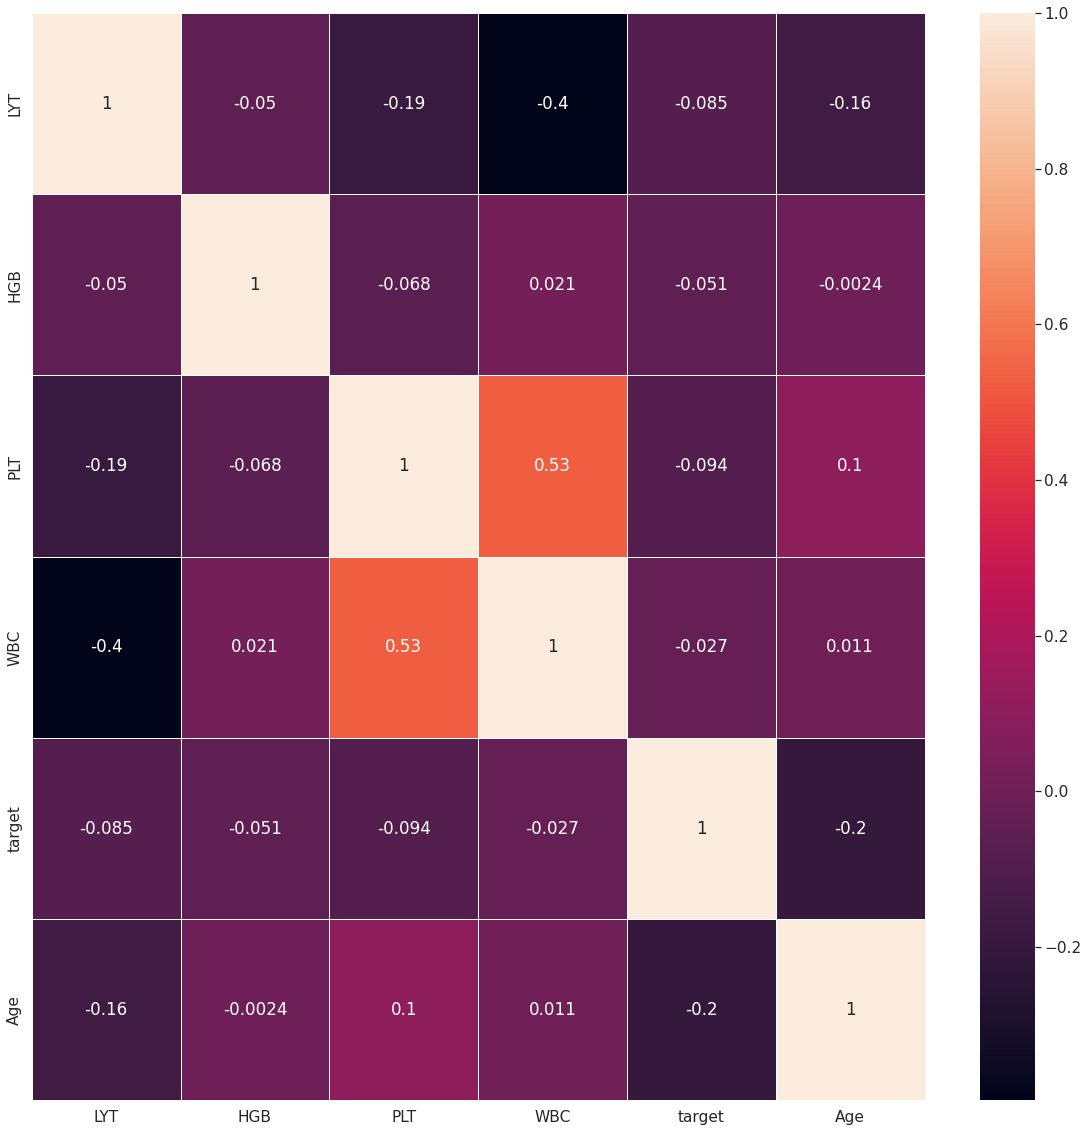

Index(['LYT', 'HGB', 'PLT', 'WBC', 'target', 'Sex', 'Age'], dtype='object')

In [39]:
sn.set(font_scale=1.4) 
fig, ax = plt.subplots(figsize=(20,20))  
plot = sn.heatmap(df_full.corr(), annot=True, linewidths=.5, ax=ax)

plot.figure.savefig('../results/prognosis_corr.png', facecolor='w')
plt.show()
df_full.columns